In [7]:
import os
import pandas as pd
import numpy as np
import sklearn.ensemble
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

%matplotlib inline
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

HousePrice1 = pd.read_csv("HousePrice1.csv")

Current working directory: /Users/chereowang27/NYCDSA/Machine_Learning_I/Machine_Learning_Project/Ames_Housing_ML


In [8]:
HousePrice2 = HousePrice1.drop(['Unnamed: 0', 'MapRefNo','PID','Unnamed: 0.1', 'Prop_Addr'], \
                               axis = 1)
num_features = HousePrice2._get_numeric_data()  \
 .drop(['MSSubClass', 'SalePrice'], axis = 1)
num_features['bath'] = num_features['FullBath'] + 0.5*num_features['HalfBath']
numCol = num_features.columns

In [9]:
numCol

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'bath'],
      dtype='object')

In [10]:
col = HousePrice2.columns
catCol = [col for col in HousePrice2.columns if col not in num_features.columns]

In [11]:
cat_features = HousePrice1[catCol]
# group Neighborhood
p_mean_by_nb = HousePrice1.groupby('Neighborhood')['SalePrice'].mean() 
nb_bin = pd.qcut(p_mean_by_nb, q = [0,0.25,.5,.75,1],
                 labels = ['tier1','tier2','tier3','tier4'])\
                .to_dict()
                 #tier1 < tier2 < tier3 < tier4
cat_features['NbPriceTier'] = cat_features['Neighborhood'].map(nb_bin)     

# create class variable to put housing price into different tiers
price_binned = pd.qcut(HousePrice1['SalePrice'], q = [0,0.25,0.5,0.75,1], 
                      )

<ipython-input-11-5b03903cfda5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_features['NbPriceTier'] = cat_features['Neighborhood'].map(nb_bin)


In [12]:
features = pd.concat([num_features, cat_features], axis = 1) \
           .drop(['GrLivArea','FullBath', 'HalfBath', \
                  'BsmtFullBath', 'BsmtHalfBath', \
                  'BsmtFinSF1','SalePrice','LandSlope','ExterQual', \
                  'Condition1','Condition2', \
                  'BsmtFinType1','BsmtFinType2', \
                  'BsmtQual', 'GarageQual','MoSold',   \
                  'BsmtFinSF2', 'BsmtUnfSF','Neighborhood'],axis = 1)
catCol = [col for col in features.columns if col not in num_features.columns]
features= pd.get_dummies(features, columns = catCol, drop_first = True)

y = HousePrice1['SalePrice']
HousePrice1['log_Price'] = np.log10(HousePrice1['SalePrice'])
logy = HousePrice1['log_Price']

In [46]:
catCol

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterCond',
 'Foundation',
 'BsmtCond',
 'BsmtExposure',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'NbPriceTier']

In [14]:
X = features
gbm = GradientBoostingRegressor()
gbm.set_params(verbose = 1)
gbm.fit(X, logy)

      Iter       Train Loss   Remaining Time 
         1           0.0247            2.34s
         2           0.0215            1.95s
         3           0.0189            1.68s
         4           0.0168            1.50s
         5           0.0150            1.37s
         6           0.0133            1.26s
         7           0.0119            1.18s
         8           0.0107            1.12s
         9           0.0098            1.07s
        10           0.0089            1.03s
        20           0.0043            0.79s
        30           0.0029            0.66s
        40           0.0023            0.55s
        50           0.0021            0.45s
        60           0.0019            0.36s
        70           0.0017            0.27s
        80           0.0016            0.18s
        90           0.0016            0.09s
       100           0.0015            0.00s


GradientBoostingRegressor(verbose=1)

In [13]:
# Parameters Tuning
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# X_train_log, X_test_log, Y_train_log, \
# Y_test_log = train_test_split(X, logy, test_size = 0.3, random_state = 0)

In [21]:
# def tune_gbm(learning_rate, max_depth):
#     gbm = GradientBoostingRegressor(
#             learning_rate = learning_rate,
#             n_estimators = 10000, 
#             max_depth = max_depth)
#     gbm.fit(X_train_log, Y_train_log)
    
#     return gbm

# def gbm_tuning(model, start = 0, end = 10000, training_curve = True):
#     gen_train = model.staged_predict(X_train_log)

#     gen_test = model.staged_predict(X_test_log)
    
#     trainMSE = []
#     testMSE = []
#     steps = range(1, 10001)
    
#     for n in steps: 
#         y_pred_train = next(gen_train)
#         y_pred_test = next(gen_test)
#         trainMSE.append(mean_squared_error(y_pred_train, Y_train_log))
#         testMSE.append(mean_squared_error(y_pred_test, Y_test_log))
#     print("The best test score is {:.2f} at the step {}".format(
#         min(testMSE), np.argmin(testMSE)+1))
#     print('-'*50)
#     plt.plot(range(start, end), testMSE[start:end])
#     if training_curve: 
#         plt.plot(range(start, end), trainMSE[start:end])

In [28]:
#GBM regressor 
import time

from sklearn.model_selection import GridSearchCV
params = {'learning_rate':[.0001,.001,.01, .1, 1] , 'max_depth':[4]} #{'learning_rate': 0.1, 'max_depth': 4}

params1 = {'learning_rate':np.linspace(0.05,.1,10) , 'max_depth':[4]}

gr_gbm = GridSearchCV(GradientBoostingRegressor(),param_grid = params1, cv = 3 )

start= time.time()
gr_gbm.fit(X,logy)
print(time.time() - start)
print(gr_gbm.best_params_)

24.08807897567749
{'learning_rate': 0.08888888888888889, 'max_depth': 4}


{'learning_rate': 0.1, 'max_depth': 4}


The best test score is 0.00 at the step 10000
--------------------------------------------------


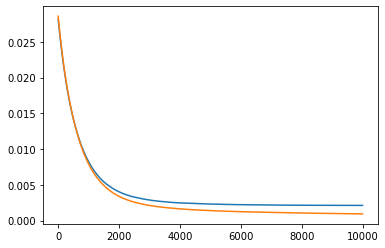

In [25]:
learning_rate = 0.001
max_depth = 4

model1 = tune_gbm(learning_rate, max_depth)
start = 0
end = 10000 
gbm_tuning(model1, start, end)

In [32]:
learning_rate = .1
max_depth = 4

model2 = tune_gbm(learning_rate, max_depth)

The best test score is 0.01 at the step 21
--------------------------------------------------


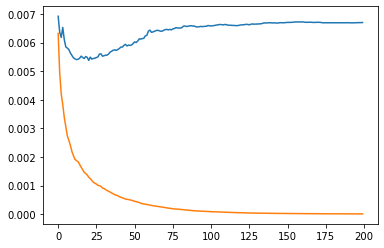

In [31]:
start = 0
end = 200
# You may change start and end to zoom in

gbm_tuning(model2, start, end)

In [ ]:
#GBM classifier multiclass